
BERT, ou Bidirectional Encoder Representations from Transformers, nada mais é do que um modelo de linguagem desenvolvido pelo próprio Google que aplica técnicas de aprendizado profundo para capturar o contexto das palavras em uma frase. Diferente de modelos tradicionais, ele processa o texto de maneira bidirecional, resultando em uma performance aprimorada em diversas tarefas de compreensão de linguagem natural.


# Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, classification_report
from transformers import TFBertModel
from tensorflow.keras import layers, Model

# Carregamento do dataset

In [3]:
# Upload do Dataset
df = pd.read_csv('bot_detection_data.csv')

# Primeiras linhas do dataset
df.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


# Exploração do dados

Nessa seção realizei análises para compreender as principais informações do dataset. Basicamente, brinquei explorando os dados do df com um objetivo de criar uma análise abrangente para entender detalhadamente o conteúdo do dataset e seu desenvolvimento, atraves dos resultados e geração de gráficos.

In [4]:
# Exibe informações gerais sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


In [5]:
# Verifica a contagem das classes de Bots vs Humanos
print("Contagem de classes:")
print(df['Bot Label'].value_counts())

Contagem de classes:
Bot Label
1    25018
0    24982
Name: count, dtype: int64


In [6]:
# Verifica se existem dados faltantes no dataset
print("Dados faltantes por coluna:")
print(df.isnull().sum())

Dados faltantes por coluna:
User ID              0
Username             0
Tweet                0
Retweet Count        0
Mention Count        0
Follower Count       0
Verified             0
Bot Label            0
Location             0
Created At           0
Hashtags          8341
dtype: int64


<Axes: title={'center': 'Distribuição do número de retweets'}, ylabel='Frequency'>

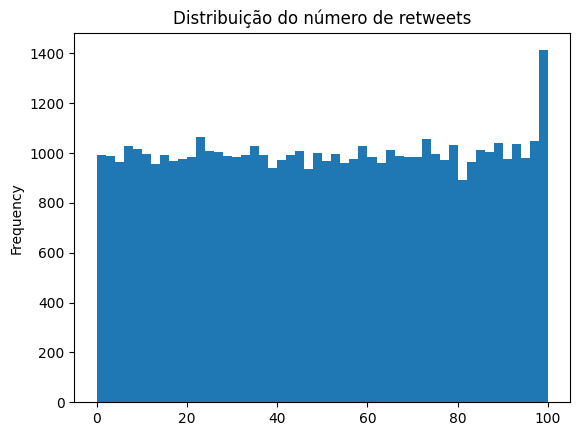

In [7]:
# Plota a distribuição do número de retweets
df['Retweet Count'].plot(kind='hist', bins=50, title="Distribuição do número de retweets")

In [8]:
# Exibe exemplos aleatórios de tweets
print(df['Tweet'].sample(5))

35518    Who reduce blue decide space market run presid...
27189    Always nor theory suggest medical east ten int...
1995               Music article pass another among never.
41427       Professor nothing prepare by manage week talk.
18423    Cause address performance question factor pare...
Name: Tweet, dtype: object


# Pré-processamento de Dados

In [9]:
# Carrega o tokenizer do BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_data(texts, labels, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenização

In [10]:
# Função de tokenização para os tweets
def tokenize_data(texts, labels, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Adiciona tokens especiais [CLS] e [SEP]
            max_length=max_len,
            padding='max_length',  # Preencher com padding até o tamanho máximo
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0), tf.convert_to_tensor(labels)


In [11]:
# Tokeniza os dados de texto
texts = df['Tweet'].astype(str).values
labels = df['Bot Label'].values

input_ids, attention_masks, labels = tokenize_data(texts, labels, tokenizer)

In [12]:
# Converte os tensores do TensorFlow para arrays NumPy
input_ids_np = np.array(input_ids)
attention_masks_np = np.array(attention_masks)
labels_np = np.array(labels)


In [13]:
# Dividir os dados em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(input_ids_np, labels_np, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(attention_masks_np, test_size=0.2, random_state=42)

# Construção do Modelo BERT no Keras

In [14]:
from transformers import TFBertForSequenceClassification
from transformers import AdamWeightDecay

In [15]:
# Carrega o modelo BERT para classificação de sequência
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Define o otimizador Adam com decaimento de peso
optimizer = AdamWeightDecay(learning_rate=2e-5)

In [17]:
# Compila o modelo manualmente
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# Treinamento do modelo

In [18]:
import tensorflow as tf

# Treinar o modelo manualmente com train_on_batch
epochs = 3
batch_size = 16
train_steps = len(X_train) // batch_size

In [19]:
# Loop de treinamento manual
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    for step in range(train_steps):
        # Pegar os lotes de dados
        batch_input_ids = X_train[step * batch_size: (step + 1) * batch_size]
        batch_attention_masks = train_masks[step * batch_size: (step + 1) * batch_size]
        batch_labels = y_train[step * batch_size: (step + 1) * batch_size]
        # Executar o treinamento
        with tf.GradientTape() as tape:
            logits = model([batch_input_ids, batch_attention_masks], training=True).logits
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(batch_labels, logits)

        # Aplicar os gradientes
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if step % 100 == 0:
            print(f"Step {step}/{train_steps}, Loss: {loss.numpy()}")

Epoch 1/3
Step 0/2500, Loss: 0.691241979598999
Step 100/2500, Loss: 0.679459810256958
Step 200/2500, Loss: 0.700683057308197
Step 300/2500, Loss: 0.6956229209899902
Step 400/2500, Loss: 0.70801842212677
Step 500/2500, Loss: 0.7156681418418884
Step 600/2500, Loss: 0.679240345954895
Step 700/2500, Loss: 0.6963201761245728
Step 800/2500, Loss: 0.709256649017334
Step 900/2500, Loss: 0.6901200413703918
Step 1000/2500, Loss: 0.7038146257400513
Step 1100/2500, Loss: 0.699013888835907
Step 1200/2500, Loss: 0.705441951751709
Step 1300/2500, Loss: 0.6841979026794434
Step 1400/2500, Loss: 0.6908525228500366
Step 1500/2500, Loss: 0.7041010856628418
Step 1600/2500, Loss: 0.6910570859909058
Step 1700/2500, Loss: 0.6914496421813965
Step 1800/2500, Loss: 0.7027266025543213
Step 1900/2500, Loss: 0.700374960899353
Step 2000/2500, Loss: 0.6950250864028931
Step 2100/2500, Loss: 0.6829185485839844
Step 2200/2500, Loss: 0.6872075796127319
Step 2300/2500, Loss: 0.6911697387695312
Step 2400/2500, Loss: 0.6933

# Avaliação do modelo

In [23]:
# Definição do tamanho do lote para a avaliação
batch_size = 16  # Valor Ajustavel

In [33]:
# Função para dividir os dados em lotes
def evaluate_in_batches(model, X_test, test_masks, batch_size=16):
    predictions = []
    true_labels = []
    num_batches = len(X_test) // batch_size

    for i in range(num_batches + 1):
        # Define os índices para o lote atual
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_test))

        if start_idx >= len(X_test):
            break

        # Obtem o lote atual de dados
        batch_input_ids = X_test[start_idx:end_idx]
        batch_attention_masks = test_masks[start_idx:end_idx]
        batch_labels = y_test[start_idx:end_idx]

        # Executa a predição no lote
        test_logits = model([batch_input_ids, batch_attention_masks], training=False).logits
        batch_predictions = tf.argmax(test_logits, axis=1)

        # Armazena as predições e os rótulos verdadeiros
        predictions.append(batch_predictions)
        true_labels.append(batch_labels)

    return np.concatenate(predictions, axis=0), np.concatenate(true_labels, axis=0)


In [34]:
from sklearn.metrics import classification_report, roc_auc_score

# Avalia o modelo em lotes
predictions, true_labels = evaluate_in_batches(model, X_test, test_masks, batch_size)

# Calcular precisão, recall, F1 score e AUC
print("Classification Report:")
print(classification_report(true_labels, predictions))

# Calcular AUC (Área sob a Curva ROC)
auc = roc_auc_score(true_labels, predictions)
print(f'AUC: {auc}')

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4968
           1       0.50      1.00      0.67      5032

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.34     10000

AUC: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Analise dos Resultados:

Os resultados obtidos mostram um desempenho insatisfatório do modelo na detecção de bots no Twitter. Vamos analisar as métricas mais profundamente para entender o que rolou:

1. Precision (Precisão):
Classe 0 (Não Bot): A precisão é 0.00, o que significa que o modelo não conseguiu identificar corretamente nenhum exemplo da classe "não bot". Isso indica que o modelo está, essencialmente, classificando todos os exemplos como "bot" (classe 1).
Classe 1 (Bot): A precisão é 0.50, o que sugere que o modelo consegue identificar bots com uma precisão moderada, mas ainda assim, metade das previsões para bots está incorreta.
2. Recall (Revocação):
Classe 0 (Não Bot): O recall é 0.00, o que significa que o modelo não foi capaz de identificar nenhum exemplo da classe "não bot".
Classe 1 (Bot): O recall é 1.00, o que significa que o modelo está identificando corretamente todos os exemplos de "bot", mas está classificando todos os exemplos como "bot", o que leva à falta de distinção entre as classes.
3. F1-Score:
Classe 0 (Não Bot): O F1 score é 0.00, refletindo o fato de que o modelo não está prevendo corretamente a classe "não bot".
Classe 1 (Bot): O F1 score é 0.67, que reflete a combinação entre precisão e recall. Apesar do recall perfeito para a classe 1, a precisão é baixa, resultando em um F1 moderado.
4. Acurácia (Accuracy):
A acurácia geral do modelo é 0.50, o que indica que o modelo está acertando 50% das previsões. No entanto, isso reflete o fato de que o modelo está simplesmente prevendo "bot" para quase todos os exemplos.
5. Macro Avg e Weighted Avg:
Macro Avg: A média macro (média das métricas das duas classes) é 0.25 para precisão, 0.50 para recall e 0.33 para F1-score, o que mostra que o modelo está muito inclinado a prever apenas uma classe (bot).
Weighted Avg: A média ponderada também reflete o mesmo padrão, com resultados baixos para todas as métricas.

##Interpretação:
 Esses resultados indicam um modelo altamente desbalanceado, onde todas ou quase todas as previsões estão sendo feitas para a classe "bot". Isso pode ocorrer quando o modelo não está conseguindo aprender as características dos "não bots" e, como resultado, está optando por uma estratégia de "classificação constante", onde prevê uma única classe (classe majoritária).

##Possíveis Causas:
- Desbalanceamento das Classes: Se os dados de treino estiverem altamente desbalanceados (muito mais exemplos de bots do que não bots), o modelo pode estar sobreajustando para a classe dominante.
- Complexidade do Modelo: O modelo BERT pode ser complexo demais para o conjunto de dados, especialmente se houver falta de variação nos dados ou se as características dos tweets não forem suficientes para distinguir claramente as duas classes.
- Tokenização Inadequada: A maneira como os textos foram tokenizados e processados pode não estar capturando adequadamente as características que distinguem bots de não bots.

##Próximos Passos:
1. Rebalanceamento do Dataset:
- Sobreamostragem ou Subamostragem: Tente técnicas como SMOTE (Synthetic Minority Over-sampling Technique) para gerar mais exemplos da classe menor, ou subamostragem da classe maior para balancear o dataset.
- Pesos de Classe: Use pesos de classe ao treinar o modelo para penalizar mais os erros na classe minoritária (não bots). Isso pode ajudar o modelo a prestar mais atenção na classe que está sendo ignorada.
2. Ajuste de Hiperparâmetros:
Ajuste a taxa de aprendizado e o número de épocas para ver se o modelo pode capturar melhor as diferenças entre as duas classes. Além disso, experimentar diferentes tamanhos de lote pode ajudar a estabilizar o treinamento.
3. Engenharia de Features Adicionais:
Além dos textos dos tweets, tente incluir features adicionais, como contagem de seguidores, retweets, uso de hashtags, etc. Essas features podem fornecer informações úteis que o modelo pode não estar capturando apenas dos textos.
4. Experimentar Modelos Mais Simples:
Como o modelo BERT é bastante complexo, você pode tentar usar modelos mais simples, como Logistic Regression, Random Forest, ou SVM, para ver se um modelo mais básico consegue aprender melhor com os dados que você possui.
5. Aumentar os Dados de Treinamento:
Se possível, tente aumentar a quantidade de dados, especialmente para a classe minoritária (não bots), o que ajudará o modelo a aprender padrões mais robustos e generalizáveis.
6. Avaliação com Métricas Adicionais:
Além das métricas tradicionais de classificação, considere analisar a curva ROC e a matriz de confusão para entender melhor os tipos de erros que o modelo está cometendo.

Esses ajustes podem ajudar a melhorar o desempenho do modelo, especialmente em datasets desbalanceados e com diferenças sutis entre as classes.